<a href="https://colab.research.google.com/github/ch697/LSTM/blob/main/LSTM_AE_train_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 0. 라이브러리 불러오기





In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import random
import seaborn as sns
sns.set(color_codes= True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import regularizers
from sklearn import metrics
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import os
os.environ["CUDA_VISIBLE_DEVICES"]=''


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 1. 데이터 불러오기


1.   CSV 형태로 되어있는 데이터를 pandas 라이브러리를 사용해 불러온다.
2.   항목 추가



In [ ]:
import pandas as pd

#정상 데이터 불러오기
normal_data_raw = pd.read_excel("/content/drive/MyDrive/LSTM_AE/train_9.xlsx")

#테스트 데이터(정상+비정상) 불러오기
test_raw = pd.read_excel("/content/drive/MyDrive/LSTM_AE/test_9.xlsx")

In [ ]:
#확인
normal_data_raw.head()

,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Flow IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Max,Bwd Packets/s
0,4,3000000.0,5.000000e+05,4.0,4,4,0,0.0,0,0.0
1,1,12000000.0,2.000000e+06,1.0,1,1,0,0.0,0,0.0
2,1,12000000.0,2.000000e+06,1.0,1,1,0,0.0,0,0.0
3,1,12000000.0,2.000000e+06,1.0,1,1,0,0.0,0,0.0
4,3,4000000.0,6.666667e+05,3.0,3,3,0,0.0,0,0.0


In [ ]:
#확인
test_raw.head()

,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Flow IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Max,Bwd Packets/s,Label
0,3,4.000000e+06,666666.66670,3.0,3,3,0,0.0,0,0.000000,0
1,109,1.100917e+05,18348.62385,109.0,109,109,0,0.0,0,9174.311927,0
2,52,2.307692e+05,38461.53846,52.0,52,52,0,0.0,0,19230.769230,0
3,34,3.529412e+05,58823.52941,34.0,34,34,0,0.0,0,29411.764710,0
4,3,4.000000e+06,666666.66670,3.0,3,3,0,0.0,0,0.000000,0


In [ ]:
normal_data_raw.isnull().sum()

 Flow Duration     0
Flow Bytes/s       0
 Flow Packets/s    0
 Flow IAT Mean     0
 Flow IAT Max      0
 Flow IAT Min      0
Bwd IAT Total      0
 Bwd IAT Mean      0
 Bwd IAT Max       0
 Bwd Packets/s     0
dtype: int64

In [ ]:
normal_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0    Flow Duration   100000 non-null  int64  
 1   Flow Bytes/s     100000 non-null  float64
 2    Flow Packets/s  100000 non-null  float64
 3    Flow IAT Mean   100000 non-null  float64
 4    Flow IAT Max    100000 non-null  int64  
 5    Flow IAT Min    100000 non-null  int64  
 6   Bwd IAT Total    100000 non-null  int64  
 7    Bwd IAT Mean    100000 non-null  float64
 8    Bwd IAT Max     100000 non-null  int64  
 9    Bwd Packets/s   100000 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 7.6 MB


In [ ]:
test_raw.isnull().sum()

 Flow Duration     0
Flow Bytes/s       0
 Flow Packets/s    0
 Flow IAT Mean     0
 Flow IAT Max      0
 Flow IAT Min      0
Bwd IAT Total      0
 Bwd IAT Mean      0
 Bwd IAT Max       0
 Bwd Packets/s     0
 Label             0
dtype: int64

In [ ]:
#pd.DataFrame -> list
normal_data_list = normal_data_raw.values.tolist()
test_list = test_raw.values.tolist()

#2. 데이터 셋 분리


1.   정상, 이상 데이터를 아래와 같이 분리해서 훈련 / 검증 / 테스트 데이터셋을 만든다.
2.   항목 추가



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

###전처리 (list 는 .shape 안됨. np.array 형태로 바꿔야)
normal_data_train = np.array(normal_data_list)
test_tot = np.array(test_list)

##테스트, 검증 데이터 만들기
x_test, x_valid, y_test, y_valid = train_test_split(test_tot[:,:-1], test_tot[:,-1], test_size = 0.3)

print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(35000, 10)
(35000,)
(15000, 10)
(15000,)


In [ ]:
test_tot.shape

(50000, 11)

In [ ]:
normal_data_train.shape

(100000, 10)

In [ ]:
normal_data_train

array([[4.00000000e+00, 3.00000000e+06, 5.00000000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.20000000e+07, 2.00000000e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.20000000e+07, 2.00000000e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 3.70000000e+07, 2.00000000e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51336980e+07, 2.44487501e+00, 2.64310812e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.14990000e+04, 5.46049081e+03, 1.26988158e+02, ...,
        3.00000000e+00, 3.00000000e+00, 6.34940792e+01]])

#3. 데이터 정규화


1.   Sklearn의 StandardScaler 라이브러리를 사용해서 훈련 / 검증 / 테스트 데이터를 정규화한다.
2.   항목 추가



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#Standard Scaler 적용
##stder.fit 오류-> 데이터에 NaN, infinity 값 제거
stder = StandardScaler()
stder.fit(normal_data_train)
x_normal_train_scaled = stder.transform(normal_data_train)
x_test_scaled = stder.transform(x_test)
x_valid_scaled = stder.transform(x_valid)


#4. 데이터 차원 변경

In [ ]:
x_normal_train_scaled = x_normal_train_scaled.reshape(x_normal_train_scaled.shape[0], 1, x_normal_train_scaled.shape[1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0],1,x_valid_scaled.shape[1])

print("훈련 정상 데이터 스케일/차원 변경 결과 : ",x_normal_train_scaled.shape)
print("검증 데이터 스케일/차원 변경 결과 : ",x_valid_scaled.shape)
print("테스트 데이터 스케일/차원 변경 결과 : ",x_test_scaled.shape)

훈련 정상 데이터 스케일/차원 변경 결과 :  (100000, 1, 10)
검증 데이터 스케일/차원 변경 결과 :  (15000, 1, 10)
테스트 데이터 스케일/차원 변경 결과 :  (35000, 1, 10)


#5. LSTM AE 모델 구현


In [ ]:
from keras.layers import  Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector

# LSTM-AE 신경망 구축(LSTM 레이어 구축)
def autoencoder_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(140, activation='relu', return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(70, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(70, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(140, activation='relu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model



In [ ]:
# LSTM-AE Model
model = autoencoder_model(x_normal_train_scaled)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 140)            84560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                59080     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 70)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 70)             39480     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 140)            118160    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 10)             1410  

In [ ]:
# 모델 학습 및 평가
nb_epochs = 100
batch_size = 32
callbacks = [EarlyStopping(monitor='val_loss',patience=7)]
history = model.fit(x_normal_train_scaled, x_normal_train_scaled, epochs=nb_epochs, batch_size=batch_size,
                     callbacks=callbacks, validation_split=0.3)
#callbacks=callbacks,

Epoch 1/100
2188/2188 [==============================] - 40s 8ms/step - loss: 0.3778 - val_loss: 0.0040
Epoch 2/100
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0921 - val_loss: 0.0048
Epoch 3/100
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0314 - val_loss: 0.0014
Epoch 4/100
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0429 - val_loss: 0.0085
Epoch 5/100
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0509 - val_loss: 0.0031
Epoch 6/100
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0404 - val_loss: 0.0055
Epoch 7/100
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0592 - val_loss: 0.0038
Epoch 8/100
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0254 - val_loss: 9.5983e-04
Epoch 9/100
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0109 - val_loss: 0.0073
Epoch 10/100
2188/2188 [==============================] - 14

In [ ]:
from tensorflow import keras
# Calling `save('my_model')` creates a SavedModel folder `my_model`. 모델 저장
model.save("/content/drive/MyDrive/LSTM_AE/LSTM_model_5")

In [ ]:
print(history.history)

{'loss': [0.22076964378356934, 0.07814216613769531, 0.03875764086842537, 0.04900545999407768, 0.059658508747816086, 0.04158725216984749, 0.09808363020420074, 0.07552304863929749, 0.011008281260728836, 0.03844551742076874, 0.019450897350907326, 0.061578091233968735, 0.023093553259968758, 0.02801026962697506, 0.03142859414219856, 0.05240768566727638, 0.030795378610491753, 0.024826113134622574, 0.03483770042657852], 'val_loss': [0.004014412872493267, 0.004779896233230829, 0.001359321759082377, 0.008533535525202751, 0.0030629602260887623, 0.005544046405702829, 0.0037626251578330994, 0.0009598270407877862, 0.00734979473054409, 0.044953178614377975, 0.006146508734673262, 0.0005785601679235697, 0.006345165893435478, 0.0007932186708785594, 0.002896389923989773, 0.002847536699846387, 0.0006989514222368598, 0.0015092595713213086, 0.0032712840475142]}


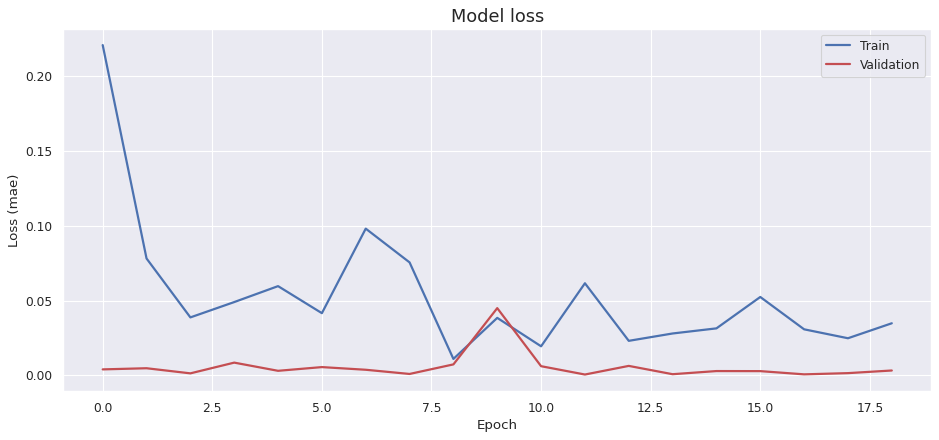

In [ ]:
#학습 손실 시각화
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history.history['loss'], 'b',label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# 6. 임계값(Threshold) 설정


1.   Sklearn에서 제공하는 precision_recall_curve 라이브러리를 사용해서 아래와 같이 임계값을 설정함
2.   항목 추가



precision:  0.9514446227929374 , recall:  0.9514446227929374
threshold:  0.0027991323302572393


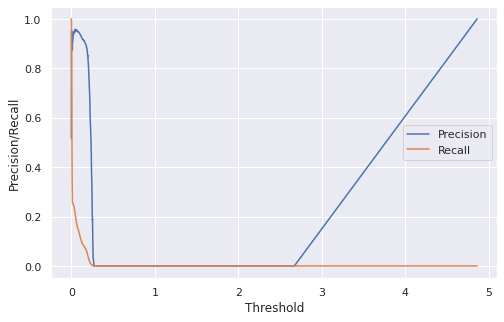

In [ ]:
#검증 데이터 입력 (결과: 입력 데이터를 재구성한 결과)
predictions_3d = model.predict(x_valid_scaled)
predictions = predictions_3d.reshape(predictions_3d.shape[0], predictions_3d.shape[2])
x_valid_ = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[2])

#재구성 손실 값 도출 (입력 데이터와 재구성 결과와의 차이)
mse = np.mean(np.power(x_valid_ - predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class':y_valid})

import pandas as pd

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

###모델 최적의 Threshold 값 찾기
best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ',precision_rt[np.argmin(best_cnt_dic)], ', recall: ',recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ',threshold_fixed)
########################

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# 8. 모델 성능 평가


1.   검증 데이터에 대해 Sklearn의 roc_curve 라이브러리를 사용해서 임계값 별 FPR, TPR 값을 도출한다.
Sklearn의 auc 라이브러리를 사용해 AUROC 값을 도출하고, Matplotlib의 Pyplot을 사용해 시각화 한다.
2.   항목 추가



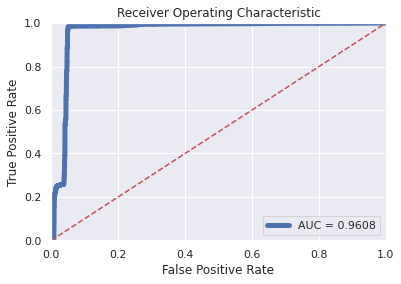

In [ ]:
from sklearn.metrics import roc_curve, auc

###모델 성능 AUC/ROC 지표
fpr, tpr, thresholds = roc_curve(y_valid, mse)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'%roc_auc, linewidth=5)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# 9. 테스트


1.   테스트 데이터에 대해 Sklearn의 confusion_matrix 라이브러리를 사용해 TN, FP, FN, TP 값을 2차원 리스트 형태로 받는다.
2.   공식을 사용해 정확도(Accuracy)를 도출한다.



0.9533142857142857


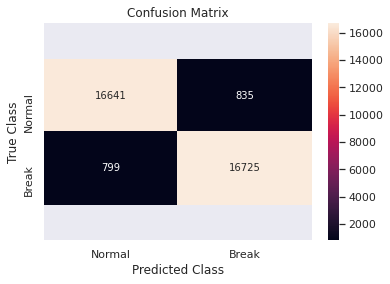

In [ ]:
# 검증 데이터 입력 (결과 : 입력 데이터를 재구성한 결과)
test_predictions_3d = model.predict(x_test_scaled)
test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0], test_predictions_3d.shape[2])
x_test_ = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[2])
mse = np.mean(np.power(x_test_ - test_predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test})
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]
conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)

accuracy = (conf_matrix[0][0]+conf_matrix[1][1])/conf_matrix.sum()
print(accuracy)

sns.heatmap(conf_matrix, xticklabels=['Normal', 'Break'], yticklabels=['Normal', 'Break'], annot=True, fmt='d', annot_kws={'size':10})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()